# **Flight Delay Prediction using Scikit-Learn Pipeline**

## **Overview**
This project demonstrates how to build a **machine learning pipeline** using scikit-learn to predict flight delays. The pipeline integrates data preprocessing with model training, ensuring efficient handling of both numerical and categorical data.

---

## **Objectives**
- Preprocess numerical and categorical data using `ColumnTransformer`.
- Automate the machine learning workflow using `Pipeline`.
- Train a **Random Forest Classifier** to predict flight delays.
- Optimize the model using **GridSearchCV** for hyperparameter tuning.

---

## **Data Overview**
- **Dataset**: Contains flight details such as:
  - **Year**, **Month**, **Day**
  - **Airline code**, **Origin airport code**, **Destination airport code**
  - **Departure delay** (target: delayed or not)

- **Target Variable**:  
  - `1` if the flight was delayed  
  - `0` if the flight was on time

---

## **Steps Involved**

### 1. **Data Loading and Exploration**
- Load the flight dataset and inspect its structure and missing values.

### 2. **Feature Engineering**
- **Numerical Features**:
  - `YEAR`, `MONTH`, `DAY`
- **Categorical Features**:
  - `AIRLINE__CODE`, `ORIGIN_AIRPORT_CODE`, `DESTINATION_AIRPORT_CODE`

### 3. **Preprocessing with `ColumnTransformer`**
- **Numerical Data**:
  - Impute missing values with the **mean**.
  - Standardize values using **`StandardScaler`**.
  
- **Categorical Data**:
  - Impute missing values with `'missing'`.
  - Encode using **`OneHotEncoder`**.

### 4. **Pipeline Setup**
- Use a **scikit-learn Pipeline** to link preprocessing and model training.
- Integrate a **Random Forest Classifier** within the pipeline.

### 5. **Model Training and Evaluation**
- Split the data into **train (70%)** and **test (30%)** sets.
- Evaluate the model using a **classification report** with metrics like:
  - **Precision**, **Recall**, **F1-score**

### 6. **Hyperparameter Tuning with GridSearchCV**
- Tune hyperparameters of the Random Forest model:
  - Number of estimators (`n_estimators`)
  - Maximum tree depth (`max_depth`)

### 7. **Model Persistence**
- Save the trained model using **`joblib`** for later use.

---

## **Technologies Used**
- **Python**: Programming language
- **Pandas**: Data manipulation and cleaning
- **Scikit-Learn**: Machine learning, preprocessing, and model evaluation
- **Joblib**: Model persistence
- **Jupyter Notebook**: Interactive development environment

---

## **Expected Output**
- A **trained Random Forest model** to predict flight delays.
- **Performance metrics** (accuracy, precision, recall) from the classification report.
- A **saved model** (`flight_delay_classifier.pkl`) for deployment.

---

## **Conclusion**
This project demonstrates how to create an automated **machine learning workflow** using scikit-learn’s `Pipeline` and `ColumnTransformer`. The streamlined preprocessing ensures consistency during both training and testing. With **hyperparameter tuning**, the model's performance is further optimized, making it reliable for real-world flight delay predictions.


# Upgrade pip and install all required packages

In [ ]:
!pip install --upgrade pip

# Install Snowflake connectors, pandas integration, and essential libraries
!pip install "snowflake-connector-python[pandas]" \
             snowflake-snowpark-python==1.12.0,<2,>=1.11.1 \
             python-dateutil tqdm holidays faker
!pip install numpy pandas matplotlib scikit-learn xgboost seaborn \

# Ensure Snowpark Python is up-to-date
!pip install --upgrade -q snowflake-snowpark-python==1.12.0,<2,>=1.11.1


# Fix potential urllib3 version conflicts
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

# Additional installations for your project
!pip install fosforml==1.1.6
!pip install python-scipy
!pip install cloudpickle==2.2.1
!pip install basemap


# Importing necessary libraries and settings

In [1]:

# Standard libraries for date and warnings
import datetime
import warnings

# Scientific and Data Manipulation Libraries
import scipy
import pandas as pd
import numpy as np

# Data Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# Sklearn Modules for Data Preprocessing, Modeling, and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # Encoding categorical variables
from sklearn.preprocessing import StandardScaler  # Scaling numerical data
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model
from sklearn.metrics import roc_auc_score, classification_report  # Evaluation metrics

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import configparser
from dateutil.relativedelta import relativedelta
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

# Configuring display options and warning filters
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

# Custom FosforML package for Snowflake session and model registration
from fosforml.model_manager.snowflakesession import get_session
from fosforml import register_model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


In [2]:
# Set Matplotlib's default font family to 'DeJavu Serif' to ensure a consistent font style across plots
plt.rcParams['font.family'] = 'DeJavu Serif'

# Establishing a Snowflake session


In [3]:
my_session = get_session()

# Defining the table name to fetch data from
# table_name = 'FLIGHTS'  # Initial option for table
table_name = 'FLIGHTS_FULL'  # Final table to be used

# Querying the data from the specified Snowflake table
sf_df = my_session.sql("SELECT * FROM {}".format(table_name))

# Converting the Snowflake DataFrame to a pandas DataFrame for local processing
df = sf_df.to_pandas()

df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE
0,2024,3,24,2,UA,1065,N53441,MCO,EWR,1032,1034.0,2.0,14.0,1048.0,166.0,149.0,128.0,937,1256.0,7.0,1318,1303.0,-15.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,United Air Lines Inc.,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,Newark Liberty International Airport,Newark,NJ,USA,40.69250,-74.16866
1,2024,3,24,2,UA,264,N855UA,SLC,IAH,1032,1027.0,-5.0,9.0,1036.0,181.0,167.0,148.0,1195,1404.0,10.0,1433,1414.0,-19.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,United Air Lines Inc.,Salt Lake City International Airport,Salt Lake City,UT,USA,40.78839,-111.97777,George Bush Intercontinental Airport,Houston,TX,USA,29.98047,-95.33972
2,2024,3,24,2,B6,518,N273JB,JFK,BOS,1033,1029.0,-4.0,17.0,1046.0,68.0,60.0,41.0,187,1127.0,2.0,1141,1129.0,-12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,JetBlue Airways,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893,Gen. Edward Lawrence Logan International Airport,Boston,MA,USA,42.36435,-71.00518
3,2024,3,24,2,EV,5372,N858AS,GTR,ATL,1033,1028.0,-5.0,11.0,1039.0,70.0,66.0,44.0,241,1223.0,11.0,1243,1234.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Atlantic Southeast Airlines,Golden Triangle Regional Airport,Columbus-Starkville-West Point,MS,USA,33.45033,-88.59137,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694
4,2024,3,24,2,HA,119,N492HA,KOA,HNL,1033,1025.0,-8.0,7.0,1032.0,44.0,43.0,28.0,163,1100.0,8.0,1117,1108.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Hawaiian Airlines Inc.,Kona International Airport at Keahole,Kailua/Kona,HI,USA,19.73877,-156.04563,Honolulu International Airport,Honolulu,HI,USA,21.31869,-157.92241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2024,2,27,5,EV,4294,N11544,SAV,EWR,1716,1712.0,-4.0,16.0,1728.0,129.0,130.0,90.0,708,1858.0,24.0,1925,1922.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Atlantic Southeast Airlines,Savannah/Hilton Head International Airport,Savannah,GA,USA,32.12758,-81.20214,Newark Liberty International Airport,Newark,NJ,USA,40.69250,-74.16866
5819075,2024,2,27,5,EV,5011,N848AS,ABE,DTW,1716,1710.0,-6.0,9.0,1719.0,109.0,99.0,84.0,425,1843.0,6.0,1905,1849.0,-16.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Atlantic Southeast Airlines,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884
5819076,2024,2,27,5,EV,6050,N12136,BHM,ORD,1716,1712.0,-4.0,12.0,1724.0,129.0,123.0,93.0,584,1857.0,18.0,1925,1915.0,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Atlantic Southeast Airlines,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,Chicago O'Hare International Airport,Chicago,IL,USA,41.97960,-87.90446
5819077,2024,2,27,5,EV,4878,N186PQ,CMH,MSP,1716,1714.0,-2.0,8.0,1722.0,127.0,112.0,102.0,626,1804.0,2.0,1823,1806.0,-17.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Atlantic Southeast Airlines,Port Columbus International Airport,Columbus,OH,USA,39.99799,-82.89188,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692


# Filtering data for specific airlines

In [4]:
# Defining the list of airlines to include in the filtered DataFrame
options = ['Southwest Airlines Co.', 'Delta Air Lines Inc.']

#df.replace({'AIRLINE':'Southwest Airlines Co.'}, {'AIRLINE': 'Southwest airlines'}, regex=True)
#df.replace({'AIRLINE':'Delta Air Lines Inc.'}, {'AIRLINE': 'Delta airlines'}, regex=True)

# Selecting rows where the 'AIRLINE' column matches one of the specified airlines
flights = df.loc[df['AIRLINE'].isin(options)]
flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE
17,2024,3,24,2,DL,935,N974DL,LGA,DTW,1035,1028.0,-7.0,39.0,1107.0,131.0,131.0,83.0,502,1230.0,9.0,1246,1239.0,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884
18,2024,3,24,2,DL,943,N977DL,MCO,LGA,1035,1030.0,-5.0,15.0,1045.0,156.0,147.0,122.0,950,1247.0,10.0,1311,1257.0,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
19,2024,3,24,2,DL,1816,N833DN,DEN,ATL,1035,1034.0,-1.0,31.0,1105.0,177.0,175.0,134.0,1199,1519.0,10.0,1532,1529.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694
24,2024,3,24,2,WN,28,N392SW,CLT,HOU,1035,1029.0,-6.0,10.0,1039.0,175.0,157.0,142.0,920,1201.0,5.0,1230,1206.0,-24.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,William P. Hobby Airport,Houston,TX,USA,29.64542,-95.27889
25,2024,3,24,2,WN,651,N604SW,DEN,MCI,1035,1120.0,45.0,20.0,1140.0,95.0,95.0,69.0,533,1349.0,6.0,1310,1355.0,45.0,0,0,None,0.0,0.0,11.0,34.0,0.0,2024-03-24,Southwest Airlines Co.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Kansas City International Airport,Kansas City,MO,USA,39.29761,-94.71391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819043,2024,2,27,5,WN,265,N714CB,PVD,MCO,1715,1714.0,-1.0,26.0,1740.0,195.0,214.0,177.0,1072,2037.0,11.0,2030,2048.0,18.0,0,0,None,18.0,0.0,0.0,0.0,0.0,2024-02-27,Southwest Airlines Co.,Theodore Francis Green State Airport,Providence,RI,USA,41.72400,-71.42822,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603
5819044,2024,2,27,5,WN,1781,N644SW,RDU,MCO,1715,1736.0,21.0,7.0,1743.0,110.0,103.0,87.0,534,1910.0,9.0,1905,1919.0,14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Southwest Airlines Co.,Raleigh-Durham International Airport,Raleigh,NC,USA,35.87764,-78.78747,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603
5819045,2024,2,27,5,WN,2187,N8641B,SAN,PHX,1715,1713.0,-2.0,9.0,1722.0,75.0,60.0,46.0,304,1908.0,5.0,1930,1913.0,-17.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Southwest Airlines Co.,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806
5819046,2024,2,27,5,WN,276,N222WN,SAT,LAX,1715,1720.0,5.0,11.0,1731.0,210.0,208.0,187.0,1211,1838.0,10.0,1845,1848.0,3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,USA,29.53369,-98.46978,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [5]:
flights = flights.dropna(subset = 'ARRIVAL_DELAY')

# Creating a copy of the filtered flights data

In [6]:
# This ensures that any modifications made to 'flights_needed_data' do not affect the original 'flights' DataFrame
flights_needed_data = flights.copy()

In [7]:
flights_needed_data.shape
#(2137736, 45)

(2112678, 45)

In [8]:
flights_needed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2112678 entries, 17 to 5819047
Data columns (total 45 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   YEAR                      int16  
 1   MONTH                     int8   
 2   DAY                       int8   
 3   DAY_OF_WEEK               int8   
 4   AIRLINE__CODE             object 
 5   FLIGHT_NUMBER             int16  
 6   TAIL_NUMBER               object 
 7   ORIGIN_AIRPORT_CODE       object 
 8   DESTINATION_AIRPORT_CODE  object 
 9   SCHEDULED_DEPARTURE       int16  
 10  DEPARTURE_TIME            float64
 11  DEPARTURE_DELAY           float64
 12  TAXI_OUT                  float64
 13  WHEELS_OFF                float64
 14  SCHEDULED_TIME            float64
 15  ELAPSED_TIME              float64
 16  AIR_TIME                  float64
 17  DISTANCE                  int16  
 18  WHEELS_ON                 float64
 19  TAXI_IN                   float64
 20  SCHEDULED_ARRIVAL         in

In [9]:
flights_needed_data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE
17,2024,3,24,2,DL,935,N974DL,LGA,DTW,1035,1028.0,-7.0,39.0,1107.0,131.0,131.0,83.0,502,1230.0,9.0,1246,1239.0,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884
18,2024,3,24,2,DL,943,N977DL,MCO,LGA,1035,1030.0,-5.0,15.0,1045.0,156.0,147.0,122.0,950,1247.0,10.0,1311,1257.0,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
19,2024,3,24,2,DL,1816,N833DN,DEN,ATL,1035,1034.0,-1.0,31.0,1105.0,177.0,175.0,134.0,1199,1519.0,10.0,1532,1529.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694
24,2024,3,24,2,WN,28,N392SW,CLT,HOU,1035,1029.0,-6.0,10.0,1039.0,175.0,157.0,142.0,920,1201.0,5.0,1230,1206.0,-24.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,William P. Hobby Airport,Houston,TX,USA,29.64542,-95.27889
25,2024,3,24,2,WN,651,N604SW,DEN,MCI,1035,1120.0,45.0,20.0,1140.0,95.0,95.0,69.0,533,1349.0,6.0,1310,1355.0,45.0,0,0,None,0.0,0.0,11.0,34.0,0.0,2024-03-24,Southwest Airlines Co.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Kansas City International Airport,Kansas City,MO,USA,39.29761,-94.71391


# Function to categorize scheduled arrival times into time segments

In [10]:
def categorize_time(SCHEDULED_ARRIVAL):
    # Categorize based on scheduled arrival time in 24-hour format
    if 500 <= SCHEDULED_ARRIVAL < 800:
        return 'Early morning'
    elif 800 <= SCHEDULED_ARRIVAL < 1100:
        return 'Late morning'
    elif 1100 <= SCHEDULED_ARRIVAL < 1400:
        return 'Around noon'
    elif 1400 <= SCHEDULED_ARRIVAL < 1700:
        return 'Afternoon'
    elif 1700 <= SCHEDULED_ARRIVAL < 2000:
        return 'Evening'
    elif 2000 <= SCHEDULED_ARRIVAL < 2300:
        return 'Night'
    elif SCHEDULED_ARRIVAL >= 2300 or SCHEDULED_ARRIVAL < 200:
        return 'Late night'
    elif 200 <= SCHEDULED_ARRIVAL < 500:
        return 'Dawn'

# Apply categorize_time function to the 'SCHEDULED_ARRIVAL' column to create 'ARRIVAL_TIME_SEGMENT'
flights_needed_data['ARRIVAL_TIME_SEGMENT'] = flights_needed_data['SCHEDULED_ARRIVAL'].apply(categorize_time)


In [11]:
flights_needed_data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE,ARRIVAL_TIME_SEGMENT
17,2024,3,24,2,DL,935,N974DL,LGA,DTW,1035,1028.0,-7.0,39.0,1107.0,131.0,131.0,83.0,502,1230.0,9.0,1246,1239.0,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884,Around noon
18,2024,3,24,2,DL,943,N977DL,MCO,LGA,1035,1030.0,-5.0,15.0,1045.0,156.0,147.0,122.0,950,1247.0,10.0,1311,1257.0,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,Around noon
19,2024,3,24,2,DL,1816,N833DN,DEN,ATL,1035,1034.0,-1.0,31.0,1105.0,177.0,175.0,134.0,1199,1519.0,10.0,1532,1529.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Afternoon
24,2024,3,24,2,WN,28,N392SW,CLT,HOU,1035,1029.0,-6.0,10.0,1039.0,175.0,157.0,142.0,920,1201.0,5.0,1230,1206.0,-24.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,William P. Hobby Airport,Houston,TX,USA,29.64542,-95.27889,Around noon
25,2024,3,24,2,WN,651,N604SW,DEN,MCI,1035,1120.0,45.0,20.0,1140.0,95.0,95.0,69.0,533,1349.0,6.0,1310,1355.0,45.0,0,0,None,0.0,0.0,11.0,34.0,0.0,2024-03-24,Southwest Airlines Co.,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Kansas City International Airport,Kansas City,MO,USA,39.29761,-94.71391,Around noon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819043,2024,2,27,5,WN,265,N714CB,PVD,MCO,1715,1714.0,-1.0,26.0,1740.0,195.0,214.0,177.0,1072,2037.0,11.0,2030,2048.0,18.0,0,0,None,18.0,0.0,0.0,0.0,0.0,2024-02-27,Southwest Airlines Co.,Theodore Francis Green State Airport,Providence,RI,USA,41.72400,-71.42822,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,Night
5819044,2024,2,27,5,WN,1781,N644SW,RDU,MCO,1715,1736.0,21.0,7.0,1743.0,110.0,103.0,87.0,534,1910.0,9.0,1905,1919.0,14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Southwest Airlines Co.,Raleigh-Durham International Airport,Raleigh,NC,USA,35.87764,-78.78747,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,Evening
5819045,2024,2,27,5,WN,2187,N8641B,SAN,PHX,1715,1713.0,-2.0,9.0,1722.0,75.0,60.0,46.0,304,1908.0,5.0,1930,1913.0,-17.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Southwest Airlines Co.,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806,Evening
5819046,2024,2,27,5,WN,276,N222WN,SAT,LAX,1715,1720.0,5.0,11.0,1731.0,210.0,208.0,187.0,1211,1838.0,10.0,1845,1848.0,3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-02-27,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,USA,29.53369,-98.46978,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,Evening


In [12]:
flights['AIRLINE__CODE'].unique()

array(['DL', 'WN'], dtype=object)

In [13]:
flights_needed_data.value_counts('DIVERTED')

DIVERTED
0    2112678
Name: count, dtype: int64

In [14]:
flights_needed_data['FLIGHT_NUMBER'] = flights_needed_data['FLIGHT_NUMBER'].astype(str)

In [15]:
flights_needed_data['MONTH'] = flights_needed_data['MONTH'].astype(str)
flights_needed_data['DAY'] = flights_needed_data['DAY'].astype(str)
flights_needed_data['DAY_OF_WEEK'] = flights_needed_data['DAY_OF_WEEK'].astype(str)
flights_needed_data['DIVERTED'] = flights_needed_data['DIVERTED'].astype(str)
flights_needed_data['CANCELLED'] = flights_needed_data['CANCELLED'].astype(str)
flights_needed_data['CANCELLED'] = flights_needed_data['CANCELLED'].astype(str)

In [16]:
flights_needed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2112678 entries, 17 to 5819047
Data columns (total 46 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   YEAR                      int16  
 1   MONTH                     object 
 2   DAY                       object 
 3   DAY_OF_WEEK               object 
 4   AIRLINE__CODE             object 
 5   FLIGHT_NUMBER             object 
 6   TAIL_NUMBER               object 
 7   ORIGIN_AIRPORT_CODE       object 
 8   DESTINATION_AIRPORT_CODE  object 
 9   SCHEDULED_DEPARTURE       int16  
 10  DEPARTURE_TIME            float64
 11  DEPARTURE_DELAY           float64
 12  TAXI_OUT                  float64
 13  WHEELS_OFF                float64
 14  SCHEDULED_TIME            float64
 15  ELAPSED_TIME              float64
 16  AIR_TIME                  float64
 17  DISTANCE                  int16  
 18  WHEELS_ON                 float64
 19  TAXI_IN                   float64
 20  SCHEDULED_ARRIVAL         in

In [17]:
flights_needed_data.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE__CODE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'FLY_DATE', 'AIRLINE',
       'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_COUNTRY',
       'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'DEST_AIRPORT', 'DEST_CITY',
       'DEST_STATE', 'DEST_COUNTRY', 'DEST_LATITUDE', 'DEST_LONGITUDE',
       'ARRIVAL_TIME_SEGMENT'],
      dtype='object')

# Correlations matrix

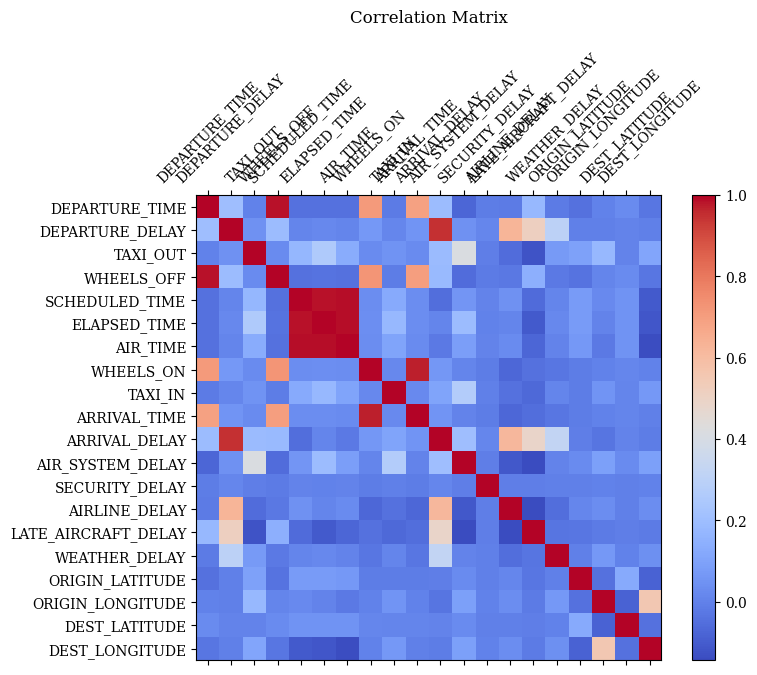

In [18]:
corr_matrix = flights_needed_data.select_dtypes([int, 'float']).corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.matshow(corr_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix", pad=20)
plt.show()

In [19]:
# Set threshold values
target_corr_threshold = 0.2
feature_corr_threshold = 0.8

# Step 1: Select features with high correlation with the target
target_corr = corr_matrix['ARRIVAL_DELAY'].abs()
high_corr_features = target_corr[target_corr > target_corr_threshold].index.tolist()
high_corr_features.remove('ARRIVAL_DELAY')  # Remove the target itself

# Step 2: Filter out highly correlated features among selected features
filtered_features = high_corr_features.copy()
for feature in high_corr_features:
    for other_feature in high_corr_features:
        if feature != other_feature and corr_matrix[feature][other_feature] > feature_corr_threshold:
            if other_feature in filtered_features:
                filtered_features.remove(other_feature)

print("Selected features for model training:", filtered_features)

Selected features for model training: ['DEPARTURE_DELAY', 'AIR_SYSTEM_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


In [20]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    if contingency_table.size == 0:
        return np.nan 

    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

categorical_cols = flights_needed_data.select_dtypes(include=['object', 'category']).columns

cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0 
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(flights_needed_data[col1], flights_needed_data[col2])

print(cramers_v_matrix)

                             MONTH       DAY DAY_OF_WEEK AIRLINE__CODE  \
MONTH                          1.0  0.048583     0.04387      0.019325   
DAY                       0.048583       1.0    0.156243      0.007194   
DAY_OF_WEEK                0.04387  0.156243         1.0      0.012022   
AIRLINE__CODE             0.019325  0.007194    0.012022           1.0   
FLIGHT_NUMBER             0.195834  0.065023     0.17037      0.600468   
TAIL_NUMBER               0.090464  0.022622    0.023348           1.0   
ORIGIN_AIRPORT_CODE        0.30261  0.007198    0.022393      0.672382   
DESTINATION_AIRPORT_CODE  0.302623  0.007177    0.022333      0.672083   
DIVERTED                       NaN       NaN         NaN           NaN   
CANCELLED                      NaN       NaN         NaN           NaN   
CANCELLATION_REASON            NaN       NaN         NaN           NaN   
FLY_DATE                       1.0       1.0         1.0      0.032913   
AIRLINE                   0.019325  0.

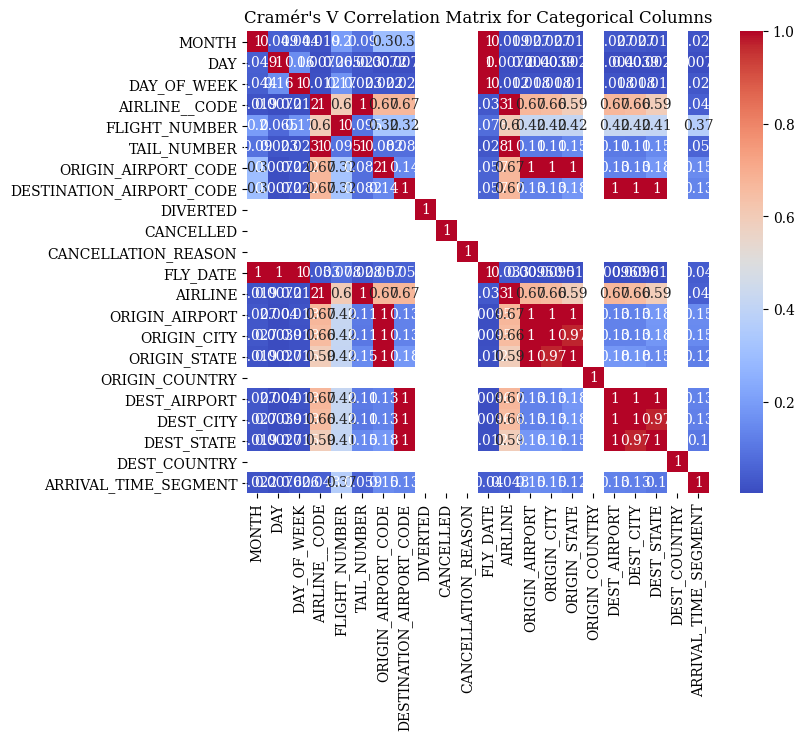

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Cramér's V Correlation Matrix for Categorical Columns")
plt.show()

In [22]:
cramers_v_matrix

,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,DIVERTED,CANCELLED,CANCELLATION_REASON,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,ARRIVAL_TIME_SEGMENT
MONTH,1.000000,0.048583,0.043870,0.019325,0.195834,0.090464,0.302610,0.302623,NaN,NaN,NaN,1.000000,0.019325,0.027026,0.026584,0.018964,NaN,0.027181,0.026736,0.019093,NaN,0.021807
DAY,0.048583,1.000000,0.156243,0.007194,0.065023,0.022622,0.007198,0.007177,NaN,NaN,NaN,1.000000,0.007194,0.003987,0.003906,0.002681,NaN,0.003996,0.003911,0.002735,NaN,0.007618
DAY_OF_WEEK,0.043870,0.156243,1.000000,0.012022,0.170370,0.023348,0.022393,0.022333,NaN,NaN,NaN,1.000000,0.012022,0.018331,0.017800,0.014842,NaN,0.018304,0.017686,0.014931,NaN,0.026139
AIRLINE__CODE,0.019325,0.007194,0.012022,1.000000,0.600468,1.000000,0.672382,0.672083,NaN,NaN,NaN,0.032913,0.999999,0.672657,0.656923,0.593426,NaN,0.672322,0.656573,0.593007,NaN,0.047784
FLIGHT_NUMBER,0.195834,0.065023,0.170370,0.600468,1.000000,0.095447,0.323178,0.324373,NaN,NaN,NaN,0.078104,0.600468,0.420579,0.418857,0.415328,NaN,0.422516,0.420226,0.411611,NaN,0.366074
TAIL_NUMBER,0.090464,0.022622,0.023348,1.000000,0.095447,1.000000,0.081756,0.081730,NaN,NaN,NaN,0.027551,1.000000,0.108444,0.106963,0.148153,NaN,0.108489,0.107020,0.148166,NaN,0.058916
ORIGIN_AIRPORT_CODE,0.302610,0.007198,0.022393,0.672382,0.323178,0.081756,1.000000,0.143862,NaN,NaN,NaN,0.057136,0.672382,1.000000,1.000000,1.000000,NaN,0.129487,0.129871,0.182832,NaN,0.152542
DESTINATION_AIRPORT_CODE,0.302623,0.007177,0.022333,0.672083,0.324373,0.081730,0.143862,1.000000,NaN,NaN,NaN,0.057136,0.672083,0.129487,0.129864,0.182900,NaN,1.000000,1.000000,1.000000,NaN,0.132537
DIVERTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
threshold = 0.6

high_association_columns = set()

for col in cramers_v_matrix.columns:
    high_values = cramers_v_matrix[col][cramers_v_matrix[col] > threshold]
    high_association_columns.update(high_values.index)

high_association_columns = list(high_association_columns)
print("Columns with Cramér's V > 0.5 with at least one other column:", high_association_columns)

Columns with Cramér's V > 0.5 with at least one other column: ['ORIGIN_AIRPORT', 'AIRLINE__CODE', 'DAY', 'CANCELLED', 'CANCELLATION_REASON', 'TAIL_NUMBER', 'DIVERTED', 'AIRLINE', 'FLY_DATE', 'ARRIVAL_TIME_SEGMENT', 'DAY_OF_WEEK', 'DEST_COUNTRY', 'FLIGHT_NUMBER', 'ORIGIN_STATE', 'DEST_CITY', 'ORIGIN_AIRPORT_CODE', 'DEST_STATE', 'ORIGIN_COUNTRY', 'ORIGIN_CITY', 'MONTH', 'DESTINATION_AIRPORT_CODE', 'DEST_AIRPORT']


# Define columns by data type

In [24]:
##numerical_cols = ['MONTH', 'DAY', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
 #                 'DISTANCE', 'SCHEDULED_ARRIVAL', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
 #                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
##categorical_cols = ['AIRLINE', 'ARRIVAL_TIME_SEGMENT']

numerical_cols = ['SCHEDULED_DEPARTURE', 'DISTANCE','SCHEDULED_ARRIVAL']                
#categorical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER','TAIL_NUMBER',
#                    'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'DEST_AIRPORT', 'DEST_CITY','ARRIVAL_TIME_SEGMENT']
categorical_cols = ['ORIGIN_AIRPORT', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT_CODE', 'AIRLINE', 'ORIGIN_CITY', 'DAY', 'DAY_OF_WEEK',
                    'DIVERTED', 'DESTINATION_AIRPORT_CODE', 'CANCELLED', 'MONTH', 'FLY_DATE', 'CANCELLATION_REASON', 'ORIGIN_COUNTRY',
                    'ORIGIN_STATE', 'ARRIVAL_TIME_SEGMENT', 'DEST_COUNTRY', 'DEST_AIRPORT', 'DEST_CITY', 'DEST_STATE',
                    'TAIL_NUMBER', 'AIRLINE__CODE']

# Creating the target column

In [25]:
# result = []
# for row in flights_needed_data['ARRIVAL_DELAY']:
#   if row > 5:
#     result.append(1)
#   else:
#     result.append(0) 

# flights_needed_data['delay_flag'] = result
# flights_needed_data.value_counts('delay_flag')

In [26]:
#test_data = flights_needed_data[flights_needed_data['MONTH'] >= 11] 
#test=test.drop(['FLY_DATE'], axis=1)
#train_data = flights_needed_data[flights_needed_data['MONTH'] < 11]

train_data  = flights_needed_data[flights_needed_data["MONTH"].apply(lambda x: '11' not in x and '12' not in x)]
test_data = flights_needed_data[flights_needed_data["MONTH"].apply(lambda x: '11' in x or '12' in x)]

In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350875 entries, 890572 to 4852420
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   YEAR                      350875 non-null  int16  
 1   MONTH                     350875 non-null  object 
 2   DAY                       350875 non-null  object 
 3   DAY_OF_WEEK               350875 non-null  object 
 4   AIRLINE__CODE             350875 non-null  object 
 5   FLIGHT_NUMBER             350875 non-null  object 
 6   TAIL_NUMBER               350875 non-null  object 
 7   ORIGIN_AIRPORT_CODE       350875 non-null  object 
 8   DESTINATION_AIRPORT_CODE  350875 non-null  object 
 9   SCHEDULED_DEPARTURE       350875 non-null  int16  
 10  DEPARTURE_TIME            350875 non-null  float64
 11  DEPARTURE_DELAY           350875 non-null  float64
 12  TAXI_OUT                  350875 non-null  float64
 13  WHEELS_OFF                350875 non-null  

In [28]:
# Replace 'target_column_name' with the actual name of your target column
X_train = train_data.drop(columns=['ARRIVAL_DELAY'])
y_train = train_data['ARRIVAL_DELAY']

# Replace 'target_column_name' with the actual name of your target column
X_test = test_data.drop(columns=['ARRIVAL_DELAY'])
y_test = test_data['ARRIVAL_DELAY']

In [29]:
X_train.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE__CODE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'FLY_DATE', 'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY',
       'ORIGIN_STATE', 'ORIGIN_COUNTRY', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DEST_AIRPORT', 'DEST_CITY', 'DEST_STATE', 'DEST_COUNTRY',
       'DEST_LATITUDE', 'DEST_LONGITUDE', 'ARRIVAL_TIME_SEGMENT'],
      dtype='object')

In [30]:
# numerical_cols = [ 'DISTANCE','AIR_TIME']                
# categorical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER','TAIL_NUMBER',
#                     'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'DEST_AIRPORT', 'DEST_CITY','ARRIVAL_TIME_SEGMENT']
# ## should add flytime if rerunning again

In [31]:
##numerical_cols = ['MONTH', 'DAY', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
 #                 'DISTANCE', 'SCHEDULED_ARRIVAL', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
 #                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
##categorical_cols = ['AIRLINE', 'ARRIVAL_TIME_SEGMENT']

numerical_cols = ['SCHEDULED_DEPARTURE', 'DISTANCE','SCHEDULED_ARRIVAL', 'AIR_TIME']                
#categorical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER','TAIL_NUMBER',
#                    'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'DEST_AIRPORT', 'DEST_CITY','ARRIVAL_TIME_SEGMENT']
categorical_cols = ['ORIGIN_AIRPORT', 'FLIGHT_NUMBER', 'AIRLINE',  'DAY', 'DAY_OF_WEEK', 'MONTH',  'ARRIVAL_TIME_SEGMENT',
                    'DEST_COUNTRY', 'DEST_AIRPORT']

# Define transformations for numerical columns: imputing and scaling

In [32]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define transformations for categorical columns: imputing and one-hot encoding


In [33]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both transformations in a ColumnTransformer


In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Create a full pipeline

In [ ]:
from xgboost import XGBRegressor

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, learning_rate=0.3, max_depth=10, subsample=0.5, random_state=42))
])
pipeline

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)

train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {train_mse}")
print(f"Training MAE: {train_mae}")
print(f"Training R²: {train_r2}")


y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")


mse_tolerance = 0.2 

if train_mse < test_mse * (1 - mse_tolerance) and train_r2 > test_r2:
    print("The model is likely overfitting.")
elif train_mse > test_mse * (1 + mse_tolerance):
    print("The model is likely underfitting.")
else:
    print("The model is likely generalizing well.")

In [ ]:
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"pipeline_model_{timestamp}.pkl"

joblib.dump(pipeline, filename)
print(f"Model saved as {filename}")

In [ ]:
from sklearn.model_selection import GridSearchCV
import joblib
from datetime import datetime
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Set verbosity to display progress
)

# Fit the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)  # Negative MSE, so we negate it to get positive MSE


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
## registering the model in Fosfor Insight Designer.
register_model(
    model_obj=best_estimator, 
    session=my_session,
    x_train=X_train_df,
    y_train=y_train_df,
    x_test=X_test_df,
    y_test=y_test_df,
    y_pred=y_pred_df,
    #y_prob=y_prob_df,
    source="Notebook",
    dataset_name="FLIGHTS",
    dataset_source="Snowflake",
    #dataset_source="InMemory",
    name="Decision_Tree_Delay_Classifier",
    description="Decision tree model trained via Notebook to identify Flight Delay application",
    flavour="sklearn",
    model_type="classification",
    conda_dependencies=["scikit-learn==1.3.2"]
)

In [ ]:
y_prob = pipeline.predict_proba(X_test)[:,1]

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
auc_score = roc_auc_score(y_test, y_pred)
auc_score

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
y_pred = pipeline.predict(flights_needed_data)

In [ ]:
flights['ACTUAL_DELAY'] = flights_needed_data['result']
flights

In [ ]:
flights['ACTUAL_DELAY_PREDICTED'] = y_pred

In [ ]:
flights[['ACTUAL_DELAY_PREDICTED', 'ARRIVAL_DELAY']]

In [ ]:
    # Ensure no NaN values remain by explicitly replacing NaN with None
my_session.write_pandas(
        df=flights,
        table_name="DELAY_REGRESSOR_OUTPUT_0511",
        database="TTH_DB",
        schema="TTH_AIRLINE_SCHEMA",
        auto_create_table=True
)

In [ ]:
flights = flights.where(pd.notnull(flights), None)

In [ ]:
flights.isna().sum()

In [ ]:
chunk_size = 1000000
chunks = [flights[i:i + chunk_size] for i in range(0, len(flights), chunk_size)]

for chunk in chunks:
    # Ensure no NaN values remain by explicitly replacing NaN with None
    chunk = chunk.where(pd.notnull(chunk), None)
    
    # # Explicitly set the data type of each column to object
    # for col in chunk.columns:
    #     chunk[col] = chunk[col].astype(object)

    # Convert the DataFrame to a Snowflake-compatible DataFrame
    ins_train_sf = my_session.createDataFrame(
        chunk.values.tolist(),
        schema=chunk.columns.tolist()
    )
    
    # Write to Snowflake
    ins_train_sf.write.mode("append").save_as_table("TTH_DB.TTH_AIRLINE_SCHEMA.DELAY_CLASSIFIER_OUTPUT_2510")

In [ ]:
len(chunks)

In [ ]:
flights.info()

In [ ]:
my_session.sql('''
CREATE TABLE IF NOT EXISTS TTH_DB.TTH_AIRLINE_SCHEMA.DELAY_CLASSIFIER_OUTPUT_2510 (
    YEAR                      INT  NULL,
    MONTH                     INT NULL,
    DAY                       INT NULL,
    DAY_OF_WEEK               INT NULL,
    AIRLINE__CODE             STRING NULL,
    FLIGHT_NUMBER             INT NULL,
    TAIL_NUMBER               STRING NULL,
    ORIGIN_AIRPORT_CODE       STRING NULL,
    DESTINATION_AIRPORT_CODE  STRING NULL,
    SCHEDULED_DEPARTURE       INT NULL,
    DEPARTURE_TIME            FLOAT NULL,
    DEPARTURE_DELAY           FLOAT NULL,
    TAXI_OUT                  FLOAT NULL,
    WHEELS_OFF                FLOAT NULL,
    SCHEDULED_TIME            FLOAT NULL,
    ELAPSED_TIME              FLOAT NULL,
    AIR_TIME                  FLOAT NULL,
    DISTANCE                  INT NULL,
    WHEELS_ON                 FLOAT NULL,
    TAXI_IN                   FLOAT NULL,
    SCHEDULED_ARRIVAL         INT NULL,
    ARRIVAL_TIME              FLOAT NULL,
    ARRIVAL_DELAY             FLOAT NULL,
    DIVERTED                  INT NULL,
    CANCELLED                 INT NULL,
    CANCELLATION_REASON       STRING NULL,
    AIR_SYSTEM_DELAY          FLOAT NULL,
    SECURITY_DELAY            FLOAT NULL,
    AIRLINE_DELAY             FLOAT NULL,
    LATE_AIRCRAFT_DELAY       FLOAT NULL,
    WEATHER_DELAY             FLOAT NULL,
    FLY_DATE                  STRING NULL,
    AIRLINE                   STRING NULL,
    ORIGIN_AIRPORT            STRING NULL,
    ORIGIN_CITY               STRING NULL,
    ORIGIN_STATE              STRING NULL,
    ORIGIN_COUNTRY            STRING NULL,
    ORIGIN_LATITUDE           FLOAT NULL,
    ORIGIN_LONGITUDE          FLOAT NULL,
    DEST_AIRPORT              STRING NULL,
    DEST_CITY                 STRING NULL,
    DEST_STATE                STRING NULL,
    DEST_COUNTRY              STRING NULL,
    DEST_LATITUDE             FLOAT NULL,
    DEST_LONGITUDE            FLOAT NULL,
    ACTUAL_DELAY              INT NULL,
    PREDICTED_DELAY           INT NULL
);

''').collect()

In [ ]:
my_session.sql('drop table  TTH_DB.TTH_AIRLINE_SCHEMA.DELAY_CLASSIFIER_OUTPUT_2510;').collect()

In [ ]:
my_session = get_session()

# Defining the table name to fetch data from
# table_name = 'FLIGHTS'  # Initial option for table
table_name = 'DELAY_CLASSIFIER_OUTPUT_2510'  # Final table to be used

# Querying the data from the specified Snowflake table
sf_df = my_session.sql("SELECT * FROM {}".format(table_name))

# Converting the Snowflake DataFrame to a pandas DataFrame for local processing
df = sf_df.to_pandas()

df

In [ ]:
df.isna().sum()